In [1]:
import time
import tensorflow as tf
import numpy as np
import glob
import imageio
import matplotlib.pyplot as plt
import os
from tensorflow.keras import layers
import time
import cv2

from models.SRGAN import RRDBNet
from models.discriminator import Discriminator_VGG_128, VGGFeatureExtractor

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

RuntimeError: cudaGetDevice() failed. Status: CUDA driver version is insufficient for CUDA runtime version

In [3]:
generator = RRDBNet(nf=64, nb=11)
discriminator = Discriminator_VGG_128()

InternalError: cudaGetDevice() failed. Status: CUDA driver version is insufficient for CUDA runtime version

In [3]:
generator.build((None, 64, 64, 3))
discriminator.build((None, 256, 256, 3))

In [4]:
discriminator.summary()

Model: "discriminator_vgg_128"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_171 (Conv2D)          multiple                  112       
_________________________________________________________________
conv2d_172 (Conv2D)          multiple                  260       
_________________________________________________________________
batch_normalization (BatchNo multiple                  16        
_________________________________________________________________
conv2d_173 (Conv2D)          multiple                  296       
_________________________________________________________________
batch_normalization_1 (Batch multiple                  32        
_________________________________________________________________
conv2d_174 (Conv2D)          multiple                  73        
_________________________________________________________________
batch_normalization_2 (Batch multiple        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


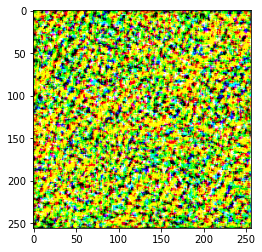

In [5]:
noise = tf.random.normal([1, 64, 64, 3])
generated_image = generator(noise)
plt.imshow(generated_image[0, :, :, :])

In [20]:
def cri_gan(x, target_is_real):
    if target_is_real:
        target_label = tf.fill(x.shape, 1.0)
    else:
        target_label = tf.fill(x.shape, 0.0)
    loss = tf.nn.sigmoid_cross_entropy_with_logits(x, target_label)
    return loss

"""
@tf.function
def train_step(self, lr, hr):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        lr = tf.cast(lr, tf.float32)
        hr = tf.cast(hr, tf.float32)

        sr = self.generator(lr)

        l_g_total = 0

        l_g_pix = 1e-2 * tf.reduce_mean(tf.abs(sr, hr))
        l_g_total += l_g_pix

        real_fea = self.netF(hr)
        fake_fea = self.netF(sr)
        l_g_fea = tf.reduce_mean(tf.abs(real_fea - fake_fea))
        l_g_total += l_g_fea

        pred_g_fake = self.discriminator(sr)
        pred_d_real = self.discriminator(hr)
        l_g_gan = 5e-3 * (
            cri_gan(pred_d_real - pred_g_fake, False) +
            cri_gan(pred_g_fake - pred_d_real, True)) / 2
        l_g_total += l_g_gan

        pred_d_real = self.discriminator(hr)
        pred_d_fake = self.discriminator(sr)
        l_d_real = cri_gan(pred_d_real - pred_d_fake, True)
        l_d_fake = cri_gan(pred_d_fake - pred_d_real, False)
        l_d_total = (l_d_real + l_d_fake) / 2

    gradients_of_generator = gen_tape.gradient(l_g_total, self.generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(l_d_total, self.discriminator.trainable_variables)

    self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
    self.discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, self.discriminator.trainable_variables))

    return l_g_total, l_d_total"""

'\n@tf.function\ndef train_step(self, lr, hr):\n    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:\n        lr = tf.cast(lr, tf.float32)\n        hr = tf.cast(hr, tf.float32)\n\n        sr = self.generator(lr)\n\n        l_g_total = 0\n\n        l_g_pix = 1e-2 * tf.reduce_mean(tf.abs(sr, hr))\n        l_g_total += l_g_pix\n\n        real_fea = self.netF(hr)\n        fake_fea = self.netF(sr)\n        l_g_fea = tf.reduce_mean(tf.abs(real_fea - fake_fea))\n        l_g_total += l_g_fea\n\n        pred_g_fake = self.discriminator(sr)\n        pred_d_real = self.discriminator(hr)\n        l_g_gan = 5e-3 * (\n            cri_gan(pred_d_real - pred_g_fake, False) +\n            cri_gan(pred_g_fake - pred_d_real, True)) / 2\n        l_g_total += l_g_gan\n\n        pred_d_real = self.discriminator(hr)\n        pred_d_fake = self.discriminator(sr)\n        l_d_real = cri_gan(pred_d_real - pred_d_fake, True)\n        l_d_fake = cri_gan(pred_d_fake - pred_d_real, False)\n      

In [6]:
img = cv2.imread('24088735_p0.jpg', cv2.IMREAD_UNCHANGED)
imgs = cv2.resize(img, dsize=(64, 64), interpolation=cv2.INTER_AREA)

In [7]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
imgs = cv2.cvtColor(imgs, cv2.COLOR_BGR2RGB)

In [12]:
img = img.astype(np.float32) / 255.
imgs = imgs.astype(np.float32) / 255.

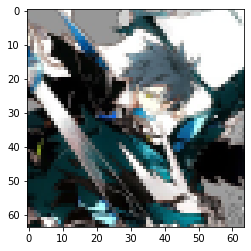

In [14]:
plt.imshow(imgs)

In [16]:
sr = generator(imgs.reshape(1, 64, 64, 3))

In [17]:
tf.reduce_mean(tf.abs(sr, img))

<tf.Tensor: shape=(), dtype=float32, numpy=0.0010867313>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


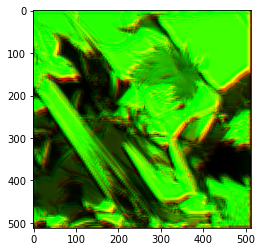

In [20]:
plt.imshow(sr[0] * 255.)

In [27]:
from tensorflow.keras.optimizers import Adam

In [28]:
generator_optimizer = Adam(learning_rate=1e-5)
discriminator_optimizer = Adam(learning_rate=1e-5)

In [33]:
def train():
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        sr = generator(imgs.reshape(1, 64, 64, 3))
        l_g_total = 0

        l_g_pix = 1e-2 * tf.reduce_mean(tf.abs(sr[0], img))
        l_g_total += l_g_pix

        pred_g_fake = discriminator(sr)
        pred_d_real = discriminator(img.reshape(1, 256, 256, 3))
        l_g_gan = 5e-3 * (
            cri_gan(pred_d_real - pred_g_fake, False) +
            cri_gan(pred_g_fake - pred_d_real, True)) / 2
        l_g_total += l_g_gan

        pred_d_real = discriminator(img.reshape(1, 256, 256, 3))
        pred_d_fake = discriminator(sr)
        l_d_real = cri_gan(pred_d_real - pred_d_fake, True)
        l_d_fake = cri_gan(pred_d_fake - pred_d_real, False)
        l_d_total = (l_d_real + l_d_fake) / 2
    gradients_of_generator = gen_tape.gradient(l_g_total, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(l_d_total, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables))

    return l_g_total, l_d_total

In [35]:
for _ in range(100):
    lg, ld = train()
    print(f"l_g : {lg}    l_d : {ld}")

l_g : [[0.0050257]]    l_d : [[1.002873]]
l_g : [[0.00502633]]    l_d : [[1.0026839]]
l_g : [[0.00502732]]    l_d : [[1.0024614]]
l_g : [[0.00502853]]    l_d : [[1.0021942]]
l_g : [[0.00502981]]    l_d : [[1.0019052]]
l_g : [[0.00503131]]    l_d : [[1.0015638]]
l_g : [[0.00503313]]    l_d : [[1.001151]]
l_g : [[0.00503533]]    l_d : [[1.0006585]]
l_g : [[0.0050379]]    l_d : [[1.0000954]]


KeyboardInterrupt: 